In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

# Import data

In [2]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")

In [3]:
print(train.shape, validation.shape)

(2430981, 25) (303925, 25)


# Import Predictions

In [4]:
# lr_preds = pd.read_csv("Prediction_csv/lr_pCTR.csv", index_col  = "Unnamed: 0")
# rf_preds = pd.read_csv("Prediction_csv/rf_pCTR.csv", index_col  = "Unnamed: 0")
xgb_preds = pd.read_csv("Prediction_csv/xgb_pCTR.csv", index_col  = "Unnamed: 0")
# dwane_preds = pd.read_csv("Prediction_csv/click_predictions_narrow.csv")
# lasso_preds = pd.read_csv("Prediction_csv/lasso_basebid.csv", index_col  = "Unnamed: 0")
# ridge_preds = pd.read_csv("Prediction_csv/ridge_basebid.csv", index_col  = "Unnamed: 0")
# elasticnet_preds = pd.read_csv("Prediction_csv/elasticnet_basebid.csv", index_col  = "Unnamed: 0")
# rfg_preds = pd.read_csv("Prediction_csv/rfg_basebid.csv", index_col  = "Unnamed: 0")
xgbr_preds = pd.read_csv("Prediction_csv/xgb_basebid.csv", index_col  = "Unnamed: 0")

In [8]:
xgbr_preds.head()

,bidid,predicted_payprice
0,bbcb813b6166538503d8b33a5602d7d72f6019dc,52.224472
1,5a07316c49477cb5d9b4d5aa39c27d6c3be7f92d,65.199875
2,f6ece71dae81d6b16bfb24ad6dd5611472d4c673,94.389198
3,b4d5c57c9b38ff5a12954fa01e11931b4e6bfbbb,46.148834
4,0899bf144249458ea9c89188473694bf44c7ca15,21.134983


# Linear Strategy

In [35]:
def Strategy(sub_pCTR, sub_basebid, C):
    
    avgCTR = sub_pCTR["click_proba"].mean()
    avgBB = sub_basebid["predicted_payprice"].mean()
    bidprice = (avgBB/sub_basebid["predicted_payprice"]) * (sub_pCTR["click_proba"]/ avgCTR) * C
    return bidprice

In [36]:
base_bid = train.loc[ train["click"] == 1, "payprice"].mean()
base_bid

105.46402677077523

In [37]:
basebids = np.linspace(0.1*base_bid, 1.5*base_bid, 100)
basebids

array([ 10.54640268,  12.03781316,  13.52922364,  15.02063412,
        16.5120446 ,  18.00345508,  19.49486555,  20.98627603,
        22.47768651,  23.96909699,  25.46050747,  26.95191795,
        28.44332843,  29.93473891,  31.42614939,  32.91755987,
        34.40897035,  35.90038083,  37.39179131,  38.88320179,
        40.37461227,  41.86602275,  43.35743323,  44.84884371,
        46.34025419,  47.83166467,  49.32307515,  50.81448563,
        52.30589611,  53.79730659,  55.28871706,  56.78012754,
        58.27153802,  59.7629485 ,  61.25435898,  62.74576946,
        64.23717994,  65.72859042,  67.2200009 ,  68.71141138,
        70.20282186,  71.69423234,  73.18564282,  74.6770533 ,
        76.16846378,  77.65987426,  79.15128474,  80.64269522,
        82.1341057 ,  83.62551618,  85.11692666,  86.60833714,
        88.09974762,  89.5911581 ,  91.08256857,  92.57397905,
        94.06538953,  95.55680001,  97.04821049,  98.53962097,
       100.03103145, 101.52244193, 103.01385241, 104.50

# Evaluate Results

In [38]:
budget = 6250*1000

def ValidationDataFrame(submission_pCTR, submission_basebid, C):
    
    validation_check = validation[["bidid", "click", "bidprice", "payprice"]]
    validation_check["click_proba"] = submission_pCTR["click_proba"]
    validation_check["bidprice_predicted"] = Strategy(submission_pCTR, submission_basebid, C)
    
    return validation_check


def ValidateStrategy(df):
    
    impressions = 0
    clicks = 0
    cost = 0
    auctions_participated = 0
    balance = budget
    
    for row in df.iterrows():
        
        if cost < budget:
            
            auctions_participated+=1
            
            if (row[1]["bidprice_predicted"] >= row[1]["payprice"]):
                
                if (balance > row[1]["bidprice_predicted"]):
                    
                    impressions+=1
                    clicks+=row[1]["click"]
                    cost+=row[1]["payprice"]
                    balance-=row[1]["payprice"]
                else:
                    pass
    
        else:
            break
    
    # Metrics
    ctr = clicks*100/impressions
    cpm = cost/impressions
    cpc = cost/clicks/1000
    
    print("Strategy statistics:")
    print("Auctions participated: {} | Impressions: {} | Clicks: {} | Cost: {} | CTR: {} | CPM: {} | CPC: {}".format(auctions_participated, \
                                                                                                                     impressions, clicks, \
                                                                                                                     cost,\
                                                                                                                     np.round(ctr,5), \
                                                                                                                     np.round(cpm,5), \
                                                                                                                     np.round(cpc,2)))
    print("\n")
            
    return impressions, clicks, cost, auctions_participated, ctr, cpm, cpc

In [40]:
pCTR_model_name = "XGBoost"
results = pd.DataFrame(columns = ["pCTR_model", "Coefficient", "Impressions", "Clicks", "Cost", "CTR", "CPM", "CPC"])
i=0

start = time.time()

for C in basebids:
    
    validation_check = ValidationDataFrame(xgb_preds, xgbr_preds, C)
    print("\033[1m pCTR model: {} \033[0m, \033[1m Constant: {} \033[0m".format(pCTR_model_name, C))
    impressions, clicks, cost, auctions_participated, ctr, cpm, cpc = ValidateStrategy(validation_check)
    results.loc[i] = [pCTR_model_name, C, impressions, clicks, cost, ctr, cpm, cpc]
    i+=1
    
end = time.time()
print("Total time: {} mins".format((end-start)/60))

 pCTR model: XGBoost ,  Constant: 10.546402677077523 
Strategy statistics:
Auctions participated: 303925 | Impressions: 23890 | Clicks: 83 | Cost: 565574 | CTR: 0.34743 | CPM: 23.67409 | CPC: 6.81


 pCTR model: XGBoost ,  Constant: 12.037813156664244 
Strategy statistics:
Auctions participated: 303925 | Impressions: 27164 | Clicks: 93 | Cost: 677310 | CTR: 0.34236 | CPM: 24.9341 | CPC: 7.28


 pCTR model: XGBoost ,  Constant: 13.529223636250965 
Strategy statistics:
Auctions participated: 303925 | Impressions: 30523 | Clicks: 97 | Cost: 799230 | CTR: 0.31779 | CPM: 26.18452 | CPC: 8.24


 pCTR model: XGBoost ,  Constant: 15.020634115837684 
Strategy statistics:
Auctions participated: 303925 | Impressions: 33624 | Clicks: 103 | Cost: 914263 | CTR: 0.30633 | CPM: 27.19079 | CPC: 8.88


 pCTR model: XGBoost ,  Constant: 16.512044595424406 
Strategy statistics:
Auctions participated: 303925 | Impressions: 36793 | Clicks: 104 | Cost: 1038292 | CTR: 0.28266 | CPM: 28.21982 | CPC: 9.98


 pC

Strategy statistics:
Auctions participated: 303925 | Impressions: 106002 | Clicks: 154 | Cost: 4700662 | CTR: 0.14528 | CPM: 44.34503 | CPC: 30.52


 pCTR model: XGBoost ,  Constant: 68.71141138095962 
Strategy statistics:
Auctions participated: 303925 | Impressions: 107360 | Clicks: 156 | Cost: 4789370 | CTR: 0.14531 | CPM: 44.61038 | CPC: 30.7


 pCTR model: XGBoost ,  Constant: 70.20282186054634 
Strategy statistics:
Auctions participated: 303925 | Impressions: 108653 | Clicks: 156 | Cost: 4870061 | CTR: 0.14358 | CPM: 44.82215 | CPC: 31.22


 pCTR model: XGBoost ,  Constant: 71.69423234013306 
Strategy statistics:
Auctions participated: 303925 | Impressions: 110005 | Clicks: 156 | Cost: 4955571 | CTR: 0.14181 | CPM: 45.0486 | CPC: 31.77


 pCTR model: XGBoost ,  Constant: 73.18564281971977 
Strategy statistics:
Auctions participated: 303925 | Impressions: 111330 | Clicks: 156 | Cost: 5043355 | CTR: 0.14012 | CPM: 45.30095 | CPC: 32.33


 pCTR model: XGBoost ,  Constant: 74.67705329

Strategy statistics:
Auctions participated: 303925 | Impressions: 121224 | Clicks: 135 | Cost: 6249998 | CTR: 0.11136 | CPM: 51.55743 | CPC: 46.3


 pCTR model: XGBoost ,  Constant: 125.38500960525498 
Strategy statistics:
Auctions participated: 303925 | Impressions: 120874 | Clicks: 134 | Cost: 6249999 | CTR: 0.11086 | CPM: 51.70673 | CPC: 46.64


 pCTR model: XGBoost ,  Constant: 126.8764200848417 
Strategy statistics:
Auctions participated: 303925 | Impressions: 120554 | Clicks: 133 | Cost: 6249998 | CTR: 0.11032 | CPM: 51.84397 | CPC: 46.99


 pCTR model: XGBoost ,  Constant: 128.3678305644284 
Strategy statistics:
Auctions participated: 303925 | Impressions: 120217 | Clicks: 131 | Cost: 6249999 | CTR: 0.10897 | CPM: 51.98931 | CPC: 47.71


 pCTR model: XGBoost ,  Constant: 129.85924104401516 
Strategy statistics:
Auctions participated: 303925 | Impressions: 119952 | Clicks: 131 | Cost: 6249998 | CTR: 0.10921 | CPM: 52.10416 | CPC: 47.71


 pCTR model: XGBoost ,  Constant: 131.3506

In [ ]:
results.to_csv("ValidationSet_Evaluation_Results_Individual_xgb_xcgr.csv")

In [41]:
results.head()

,pCTR_model,Coefficient,Impressions,Clicks,Cost,CTR,CPM,CPC
0,XGBoost,10.546403,23890,83,565574,0.347426,23.674090,6.814145
1,XGBoost,12.037813,27164,93,677310,0.342365,24.934104,7.282903
2,XGBoost,13.529224,30523,97,799230,0.317793,26.184517,8.239485
3,XGBoost,15.020634,33624,103,914263,0.306329,27.190786,8.876340
4,XGBoost,16.512045,36793,104,1038292,0.282662,28.219824,9.983577


In [43]:
results.sort_values(by = ["Clicks"], ascending = False)

,pCTR_model,Coefficient,Impressions,Clicks,Cost,CTR,CPM,CPC
57,XGBoost,95.556800,128523,159,6233840,0.123713,48.503692,39.206541
56,XGBoost,94.065390,127453,159,6157716,0.124752,48.313621,38.727774
55,XGBoost,92.573979,126402,159,6082807,0.125789,48.122712,38.256648
54,XGBoost,91.082569,125391,159,6009645,0.126803,47.927244,37.796509
53,XGBoost,89.591158,124301,159,5935245,0.127915,47.748972,37.328585
50,XGBoost,85.116927,121019,158,5706005,0.130558,47.149662,36.113956
48,XGBoost,82.134106,118739,158,5545276,0.133065,46.701387,35.096684
45,XGBoost,77.659874,115180,158,5300633,0.137177,46.020429,33.548310
46,XGBoost,79.151285,116381,158,5384776,0.135761,46.268515,34.080861
47,XGBoost,80.642695,117550,158,5463451,0.134411,46.477678,34.578804


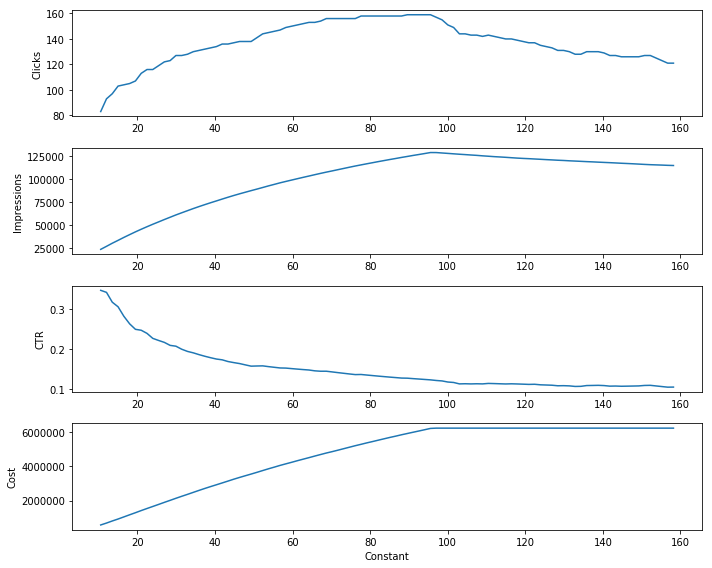

In [52]:
plt.figure(figsize = (10,8))

plt.subplot(4,1,1)
plt.plot(basebids, results["Clicks"])
plt.ylabel("Clicks")

plt.subplot(4,1,2)
plt.plot(basebids, results["Impressions"])
plt.ylabel("Impressions")

plt.subplot(4,1,3)
plt.plot(basebids, results["CTR"])
plt.ylabel("CTR")

plt.subplot(4,1,4)
plt.plot(basebids, results["Cost"])
plt.ylabel("Cost")
plt.xlabel("Constant")

plt.tight_layout()